In [1]:
import os

import cv2
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

TRAIN_PATH = r'D:\code-example\my_research\mnist_cnn\printed_digit\data\train'
TEST_PATH = r'D:\code-example\my_research\mnist_cnn\printed_digit\data\test'
VALID_PATH = r'D:\code-example\my_research\mnist_cnn\printed_digit\data\validation'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## **1. LOAD AND PREPROCESS IMAGE**

In [2]:
# load dataset
X_train = []; X_test = []; X_VALID = []
Y_train = []; Y_test = []; Y_VALID = []

for folder_number in os.listdir(TRAIN_PATH):
    for file_name in os.listdir(os.path.join(TRAIN_PATH,folder_number)):
        img = cv2.imread(os.path.join(TRAIN_PATH,folder_number,file_name),0)
        X_train.append(img)
        Y_train.append(folder_number)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

for folder_number in os.listdir(TEST_PATH):
    for file_name in os.listdir(os.path.join(TEST_PATH,folder_number)):
        img = cv2.imread(os.path.join(TEST_PATH,folder_number,file_name),0)
        X_test.append(img)
        Y_test.append(folder_number)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

for folder_number in os.listdir(VALID_PATH):
    for file_name in os.listdir(os.path.join(VALID_PATH,folder_number)):
        img = cv2.imread(os.path.join(VALID_PATH,folder_number,file_name),0)
        X_VALID.append(img)
        Y_VALID.append(folder_number)
X_VALID = np.array(X_VALID)
Y_VALID = np.array(Y_VALID)

In [3]:
#shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

s = np.arange(X_VALID.shape[0])
np.random.shuffle(s)
X_VALID = X_VALID[s]
Y_VALID = Y_VALID[s]

In [4]:
#preprocessing
x_train = X_train / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = X_test / 255.0
x_test = x_test.reshape(-1, 28, 28, 1)
x_valid = X_VALID / 255.0
x_valid = x_valid.reshape(-1, 28, 28, 1)

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)
y_valid = to_categorical(Y_VALID)

## **2. CNN Model**

In [5]:
model = Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation="relu"))

model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [6]:
# With data augmentation to prevent overfitting
batch_size = 128

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.01,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# datagen.fit(X_train)
train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)
valid_gen = datagen.flow(x_valid, y_valid, batch_size=batch_size)
test_gen = datagen.flow(x_test, y_test, batch_size=batch_size)

In [7]:
epochs = 20
train_steps = x_train.shape[0] // batch_size
valid_steps = x_valid.shape[0] // batch_size

es = EarlyStopping(
    monitor="val_acc",  # metrics to monitor
    patience=10,  # how many epochs before stop
    verbose=1,
    mode="max",  # we need the maximum accuracy.
    restore_best_weights=True,  #
)

rp = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.2,
    patience=3,
    verbose=1,
    mode="max",
    min_lr=0.00001,
)

In [8]:
# Fit the model
history = model.fit(train_gen,
                              epochs = epochs,
                              steps_per_epoch = train_steps,
                              validation_data = valid_gen,
                              validation_steps = valid_steps,
                             callbacks=[es, rp])

Epoch 1/20
241/241 [==============================] - 24s 51ms/step - loss: 0.0313 - accuracy: 0.9914 - val_loss: 2.9399 - val_accuracy: 0.2251 - lr: 0.0010
Epoch 2/20
241/241 [==============================] - 12s 49ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.1288 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 3/20
241/241 [==============================] - 13s 53ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0871 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 4/20
241/241 [==============================] - 12s 49ms/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 0.0081 - val_accuracy: 0.9985 - lr: 0.0010
Epoch 5/20
241/241 [==============================] - 12s 51ms/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 0.0048 - val_accuracy: 0.9989 - lr: 0.0010
Epoch 6/20
241/241 [==============================] - 12s 50ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0049 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 7/20
241/241 [==============================] - 12s 

In [9]:
score_train = model.evaluate(x_train,y_train)
score_test = model.evaluate(x_test, y_test)
print('score-train: ',score_train)
print('score-test: ',score_test)
print('score-train using gen: ',model.evaluate(train_gen))
print('score-test using gen: ',model.evaluate(test_gen))

165/165 [==============================] - 1s 4ms/step - loss: 10.4970 - accuracy: 0.9992
score-train:  [9.217299461364746, 0.9991596341133118]
score-test:  [10.497032165527344, 0.9992382526397705]
242/242 [==============================] - 10s 42ms/step - loss: 0.0016 - accuracy: 0.9994
score-train using gen:  [0.0016232330817729235, 0.9994181990623474]
42/42 [==============================] - 2s 43ms/step - loss: 5.6984 - accuracy: 0.9989
score-test using gen:  [5.698404788970947, 0.9988573789596558]


In [10]:
y_pre = model.predict(x_test)

165/165 [==============================] - 0s 2ms/step


In [11]:
np.sum(np.argmax(y_pre,axis=1) == np.argmax(y_test,axis=1))/y_test.shape[0]

0.9992382403351743

# **3. Evaluate the model**
## ***3.1 Training and validation curves***

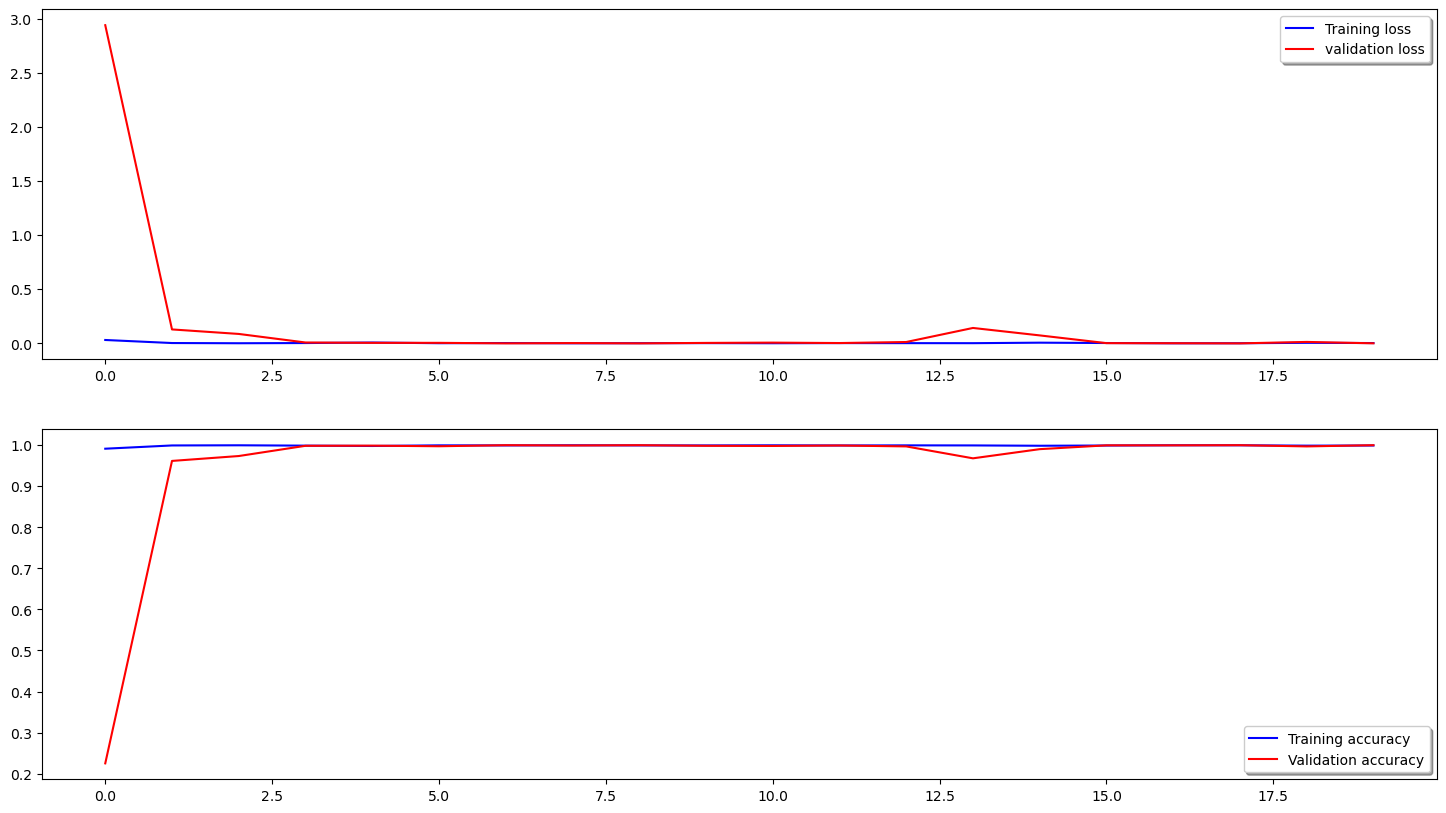

In [12]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## ***3.2 Confusion matrix***

165/165 [==============================] - 0s 2ms/step


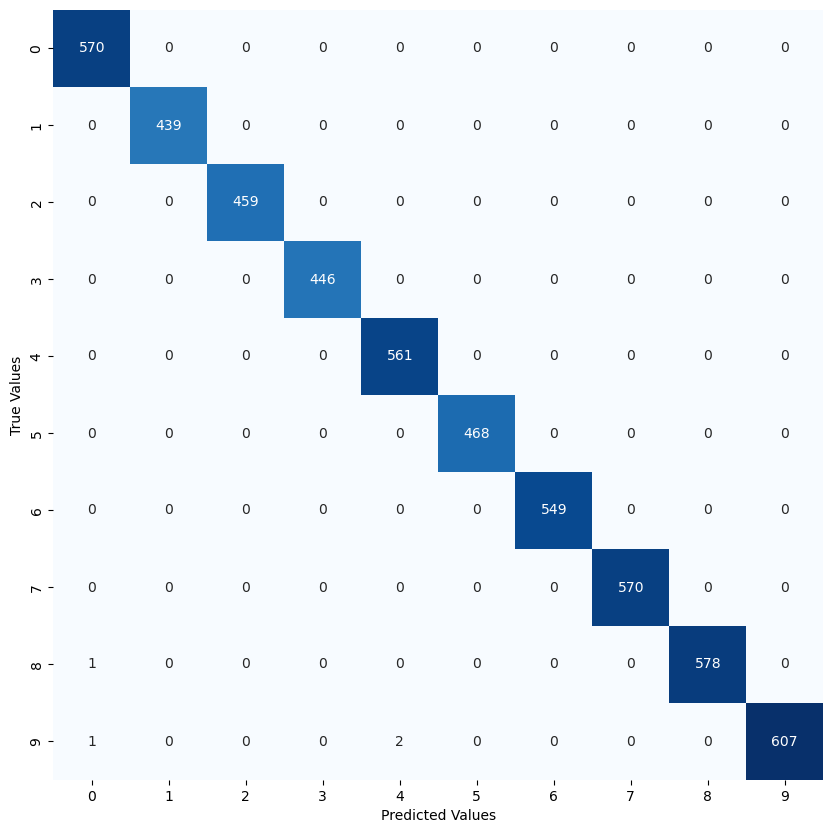

In [13]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(x_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

## **4. Prediction and submition**
## ***4.1 Prediction validation results***

165/165 [==============================] - 0s 2ms/step


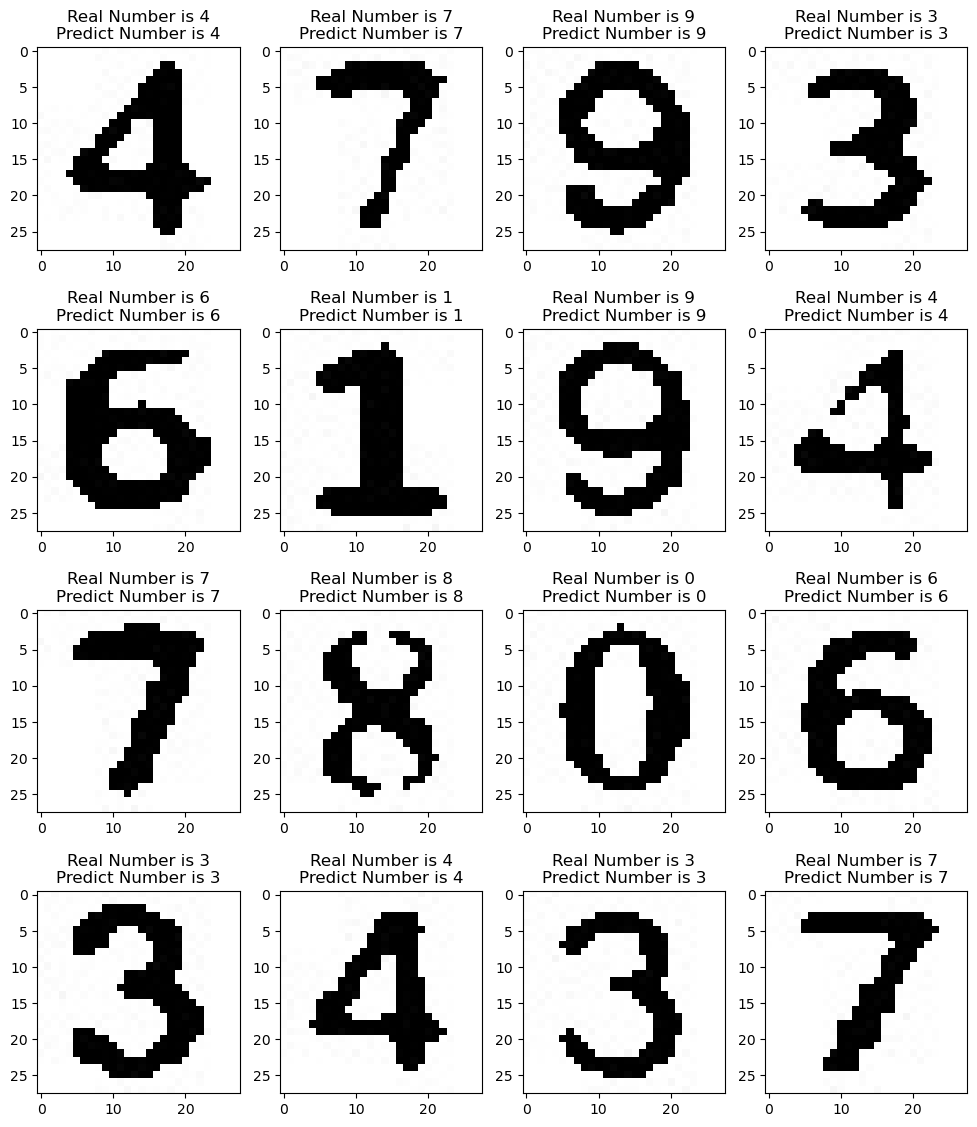

In [14]:
y_pred = model.predict(x_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

## ***4.2 Submition***

In [15]:
# Evaluate the model
score = model.evaluate(x_test,y_test)
print(score)

165/165 [==============================] - 1s 4ms/step - loss: 10.4970 - accuracy: 0.9992
[10.497032165527344, 0.9992382526397705]


In [17]:
import pickle

# Lưu mô hình ở định dạng h5
model.save('v1_printed_digits_cnn.h5')

# Lưu mô hình ở định dạng hdf5
model.save_weights('v1_printed_digits_cnn.hdf5')

# Lưu mô hình ở định dạng pkl
pickle.dump(model, open('v1_printed_digits_cnn.pkl', 'wb'))
